# Generate random data

In [8]:
import csv
import random
import os
from math import ceil
def generate_random_data(filepath, rows):
    # Get the data:
    year_start = 2000
    year_end = 2016
    queries = ceil(rows / (year_end - year_start + 1))
    with open(filepath, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["query-id", "year", "ucla", "ucd", "ucl", "ucsd", "ucsf"])
        for query_id in range(1, queries + 1):
            for year in range(year_start, year_end + 1):
                row = [query_id, year]
                for _ in range(5):
                    row.append(random.randrange(0, 40000000))
                writer.writerow(row)
os.makedirs("data", exist_ok=True)
for rows in [30, 10000]:#, 50000, 500000]:
    generate_random_data("data/random-%s-data" % rows, rows)

# Random data statistics

In [10]:
import csv
import pandas as pd
from IPython.display import display, HTML, clear_output

preview_row_count = 10

filepath = "data/random-10000-data"
with open(filepath, "r") as f:
    reader = csv.reader(f)
    num_of_columns, num_of_rows = 0, 0
    column_ranges = []
    header = []
    preview_rows = []
    for row in reader:
        if len(preview_rows) <= preview_row_count:
            preview_rows.append(row)
        if not header:
            header = row
            continue
        num_of_columns = len(row)
        num_of_rows += 1
        if not column_ranges:
            column_ranges = [[50000000, 0] for i in range(num_of_columns)]
        for col_num, column in enumerate(row):
            if not column.isdigit():
                continue
            column_ranges[col_num][0] = min(column_ranges[col_num][0], int(column))
            column_ranges[col_num][1] = max(column_ranges[col_num][1], int(column))
    print("Number of columns: ", num_of_columns)
    print("Number of rows: ", num_of_rows)
    
    min_max_table = [[header[i]] + rng for i, rng in enumerate(column_ranges)]
    df = pd.DataFrame(min_max_table, columns=["name", "min", "max"])
    range_html = "<h3>Min/Max values table</h3>" + df.to_html(index=False)
        
    df = pd.DataFrame(preview_rows[1:], columns=preview_rows[0])
    data_html = "<h3>First 10 rows of the data</h3>" + df.head(preview_row_count).to_html(index=False)
    
    display(HTML("<div>%s</div><div>%s</div>" % (range_html, data_html)))

Number of columns:  7
Number of rows:  10013


# Year graphs

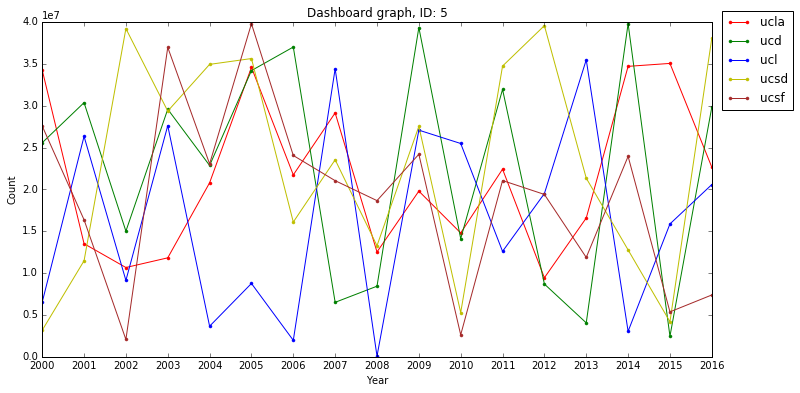

In [11]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import importlib
from ipywidgets import widgets
%matplotlib inline

if not filepath:
    filepath = "data/random-10000-data"
input_graph_queries = widgets.Text()

def filter_queries(query_ids, year=None, group_queries=False):
    """
    @param group_queries: groups all queries that 
        have the same id into the same dictionary key
    @return: {query_id: [queries]} if group_queries else [queries]
    """
    if year:
        year = str(year)
    filtered_queries = dict() if group_queries else []
    header = []
    with open(filepath, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if not header:
                header = row
            if row[0] in query_ids and (True if year is None else row[1] == year):
                if group_queries:
                    if row[0] not in filtered_queries:
                        filtered_queries[row[0]] = []
                    filtered_queries[row[0]].append([int(i) for i in row]);
                else:
                    filtered_queries.append([int(i) for i in row])
    return header, filtered_queries

def draw_graph(lines, line_names, x_data, title, xlabel):
    # Draw graph
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    opacity = 0.4
    colors = ["r", "g", "b", "y", "brown"]
    for i, column in enumerate(lines):
        if 0:
            plt.bar(x_data, column, bar_width,
                    color=colors[i],
                    label=line_names[i]) # Skip year and query_id
        else:
            plt.errorbar(x_data, column, color=colors[i], label=line_names[i], fmt="b.-")

    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(x_data)
    plt.legend(bbox_to_anchor=(1.13, 1.05))

    #plt.tight_layout()
    plt.show() # Used for new graph   
    
def handle_input_queries(sender):    
    queries_to_find = sender.value.split(",")
    header, filtered_queries = filter_queries(queries_to_find, group_queries=True)
    clear_output(wait=True) # Remove all graphs
    for query_id in queries_to_find:
        if query_id not in filtered_queries:
            print("No match found for '%s'" % query_id)
            continue

        # Translate graph values from row.column to column.row
        query = filtered_queries[query_id]
        columns = list(zip(*query))

        # Draw graph
        draw_graph(columns[2:], header[2:], columns[1], 'Dashboard graph, ID: %s' % (query_id,), "Year")
    
input_graph_queries.on_submit(handle_input_queries)
input_graph_queries

# Query id graphs

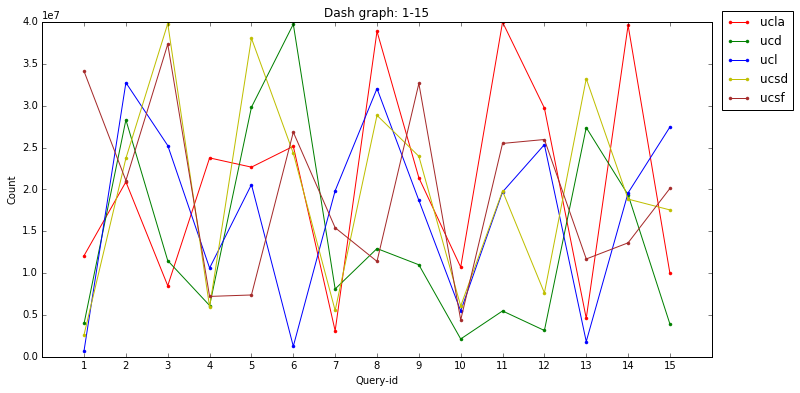

In [14]:
#filepath = "data/random-10000-data"
input_year = 2016

if not filepath:
    filepath = "data/random-10000-data"

print("Use 'x-y' for range(end including) and 'x,y,z...' for list")
input_graph_queries = widgets.Text()
def handle_input_queries(sender):
    # Parse input range or list
    if("-" in sender.value):
        queries_to_find = sender.value.split("-")
        queries_to_find = [int(i) for i in queries_to_find]
        queries_to_find = [str(i) for i in range(queries_to_find[0], queries_to_find[1]+1)]
    else:
        queries_to_find = sender.value.split(",")
    
    # Filter queries from data
    header, filtered_queries = filter_queries(queries_to_find, input_year)
    if not filtered_queries:
        print("No match found for '%s'" % sender.value)
        return
        
    # Translate row.column into column.row
    columns = list(zip(*filtered_queries))
    
    # Draw graph
    clear_output(wait=True) # Remove graph
    draw_graph(columns[2:], header[2:], columns[0], 'Dash graph: %s' % (sender.value,), "Query-id")
        
    
input_graph_queries.on_submit(handle_input_queries)

input_graph_queries

-14